## Analysis of Data Professionals in 2017/2018

**Through the analysis, I'd like to know**

* __The preference of database management systems__
* __Distribution of data related jobs__
* __Job Locations - Countries__
* __The most popular data job's median/average salaries__
* __Corrleation between salaries and experience__
* __Corrleation between salaries and education__

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import OrderedDict
from sklearn import preprocessing

In [2]:
prof_table = pd.read_csv(r'datasets\2018_Data_Professionals_Salary.csv', encoding='latin1')
print(prof_table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6011 entries, 0 to 6010
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   SalaryUSD               6011 non-null   object
 1   Country                 6011 non-null   object
 2   PrimaryDatabase         6011 non-null   object
 3   YearsWithThisDatabase   6011 non-null   int64 
 4   OtherDatabases          4779 non-null   object
 5   JobTitle                6011 non-null   object
 6   YearsWithThisTypeOfJob  6011 non-null   int64 
 7   Education               6011 non-null   object
 8   HoursWorkedPerWeek      6011 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 422.8+ KB
None


## Data Cleaning

In [3]:
prof_table.head()

,SalaryUSD,Country,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,JobTitle,YearsWithThisTypeOfJob,Education,HoursWorkedPerWeek
0,200000,United States,Microsoft SQL Server,10,MySQL/MariaDB,DBA,5,Masters,45
1,61515,United Kingdom,Microsoft SQL Server,15,"Oracle, PostgreSQL",DBA,3,None (no degree completed),35
2,95000,Germany,Microsoft SQL Server,5,"Oracle, MySQL/MariaDB, Informix",Other,25,Masters,45
3,56000,United Kingdom,Microsoft SQL Server,6,NaN,DBA,2,Associates (2 years),40
4,35000,France,Microsoft SQL Server,10,Oracle,DBA,10,Bachelors (4 years),40


In [4]:
def object_to_int(object_list):
    '''
    return a list of int by transforming an object list that should've been of data type: int
    
        Args:
            object_list (series): a list of int-like objects
        return:
            Series of integers
    '''
    object_list = object_list.str.replace(',', '').str.replace('$', '').str.replace(' ', '')
    return object_list.astype(float).astype(int)

# drop the unwanted column
prof_table.drop(columns='OtherDatabases', inplace=True)
# rename columns for convenience
prof_table.rename(columns={'SalaryUSD':'SALARY_USD', 'Country':'COUNTRY', 'PrimaryDatabase':'DBMS', 
                           'YearsWithThisDatabase':'DBMS_YEARS', 'JobTitle':'JOB_TITLE',
                           'YearsWithThisTypeOfJob':'EXPERIENCE', 'Education':'EDUCATION',
                           'HoursWorkedPerWeek':'WEEKLY_HOUR'}, inplace=True)
# transform the data type of the series to int
prof_table['SALARY_USD'] = object_to_int(prof_table['SALARY_USD'])
prof_table.drop_duplicates(inplace=True)

# seeing if there is any invalid values
print(prof_table.isnull().sum())

SALARY_USD     0
COUNTRY        0
DBMS           0
DBMS_YEARS     0
JOB_TITLE      0
EXPERIENCE     0
EDUCATION      0
WEEKLY_HOUR    0
dtype: int64


In [5]:
# finding outliers in the salary column
print(prof_table['SALARY_USD'].sort_values().head(10))
print()
print(prof_table['SALARY_USD'].sort_values().tail(10))

5589      0
3567     38
2963     44
4316     56
5198     58
4179     81
5259     87
3259     92
5353    112
3563    126
Name: SALARY_USD, dtype: int32

4849     705000
1873     785000
5426     800000
3796     832031
5115     960000
4733    1000000
2153    1000000
4413    1375000
3085    1450000
1014    1450000
Name: SALARY_USD, dtype: int32


The upper limit of salary is probable; however, the lower end seems to have some data that's needed to be filtered.

I'm going to set 1000 as the minimum boundary.

In [6]:
drop_indexes = prof_table.loc[prof_table['SALARY_USD'] < 1000].index
prof_table.drop(index=drop_indexes, inplace=True)

print('Unique values of experience')
print(sorted(prof_table['EXPERIENCE'].unique()))

Unique values of experience
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


## Preferred Primary Database Management Systems (DBMS)

In [7]:
primary_list = prof_table['DBMS'].value_counts().index
primary_count = (prof_table['DBMS'].value_counts().values)
print(prof_table['DBMS'].value_counts())

Microsoft SQL Server       5601
Oracle                      194
PostgreSQL                   33
Other                        30
MySQL/MariaDB                23
Azure SQL DB                 18
DB2                          15
Microsoft Access             12
Teradata                     10
SAP                           9
Amazon RDS (any flavor)       8
MongoDB                       6
SQLite                        3
Elasticsearch                 2
Cassandra                     2
Name: DBMS, dtype: int64


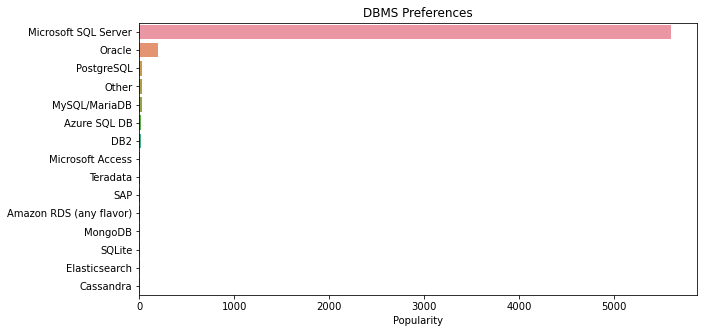

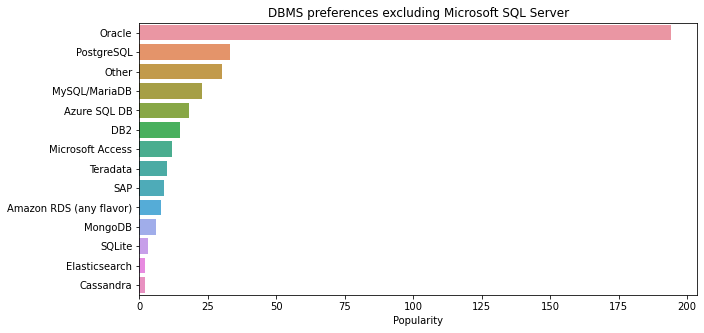

In [8]:
# creating a graph of primary databases
plt.figure(figsize=(10,5))
sns.barplot(x = primary_count, y = primary_list)
plt.xlabel('Popularity')
plt.title('DBMS Preferences')
plt.tight_layout
plt.show()

# creating another graph without MS SQL Server stats
plt.figure(figsize=(10,5))
sns.barplot(x = primary_count[1:], y = primary_list[1:])
plt.xlabel('Popularity')
plt.title('DBMS preferences excluding Microsoft SQL Server')
plt.tight_layout
plt.show()

* ### Observations

Microsoft SQL Server is by far the most used DBMS for companies across the world

Oracle seems to be popular among all other options

## Most popular data jobs 

* ### Grouping similar jobs together

In [9]:
print('Data jobs before filtering')
print(prof_table['JOB_TITLE'].unique())

Data jobs before filtering
['DBA' 'Other' 'Developer: App code (C#, JS, etc)' 'Engineer'
 'Developer: T-SQL'
 'Developer: Business Intelligence (SSRS, PowerBI, etc)' 'Architect'
 'Analyst' 'Manager' 'Data Scientist' 'Principal database engineer'
 'DevOps, Sr Software Engineer DBA' 'Technician ' 'Database Specialist'
 'Consultant' 'Systems Administrator' 'Sales' 'DBA / BI Developer'
 'Sr Consultant ' 'Analytics consultant'
 'DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers)'
 'DBA (Development Focus - tunes queries, indexes, does deployments)'
 'DBA (Production Focus - build & troubleshoot servers, HA/DR)']


In [10]:
job_list = prof_table['JOB_TITLE'].unique()

# update the job list directly
for job in job_list:
    job_indexes = prof_table[prof_table['JOB_TITLE'] == job].index
    if 'dba' in job.lower():
        prof_table.at[job_indexes, 'JOB_TITLE'] = 'DBA'
    elif 'developer' in job.lower():
        prof_table.at[job_indexes, 'JOB_TITLE'] = 'Developer'
    elif 'consultant' in job.lower():
        prof_table.at[job_indexes, 'JOB_TITLE'] = 'Consultant'
    elif 'engineer' in job.lower():
        prof_table.at[job_indexes, 'JOB_TITLE'] = 'Engineer'        
    else:
        pass

print('Data jobs after filtering')
print(prof_table['JOB_TITLE'].unique())

Data jobs after filtering
['DBA' 'Other' 'Developer' 'Engineer' 'Architect' 'Analyst' 'Manager'
 'Data Scientist' 'Technician ' 'Database Specialist' 'Consultant'
 'Systems Administrator' 'Sales']


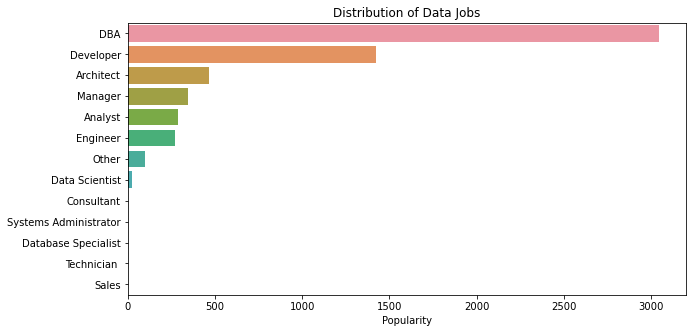

In [11]:
job_list, job_count = prof_table['JOB_TITLE'].value_counts().index, prof_table['JOB_TITLE'].value_counts().values
job_count_sum = prof_table['JOB_TITLE'].value_counts().values.sum()
job_pct = (job_count/job_count_sum)*100

plt.figure(figsize=(10, 5))
sns.barplot(x = job_count, y = job_list)
plt.xlabel('Popularity')
plt.title('Distribution of Data Jobs')
plt.show()

* ### Where are these jobs offered?

           COUNTRY  JOB_TITLE
79   United States       3881
78  United Kingdom        595
11          Canada        213
2        Australia        159
33           India        106
70          Sweden         80
25         Germany         80
50     Netherlands         69
68    South Africa         53
51     New Zealand         47


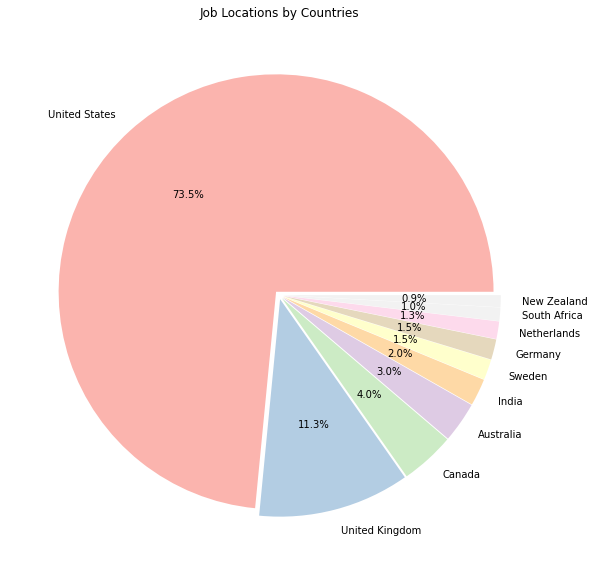

In [12]:
# Let's find job locations
job_locations = prof_table[['COUNTRY', 'JOB_TITLE']].groupby('COUNTRY', as_index=False).count()
job_locations = job_locations.sort_values(by='JOB_TITLE', ascending=False).head(10)  # top 10 countries
print(job_locations)

colors = [plt.cm.Pastel1(i) for i in range(len(job_locations))]
job_countries = job_locations['COUNTRY']
job_count = job_locations['JOB_TITLE']

plt.figure(figsize=(10,10))
plt.pie(job_count,  explode=[0.02]*len(job_count),labels=job_countries, autopct='%1.1f%%', colors=colors)
plt.title('Job Locations by Countries')
plt.show()

* ### Observations

Given the scarcity of data, it's difficult to make a definite conclusion; however, this sample still gives a good sense of the bigger picture. 

America is by far the most dominant in providing data job opportunities. Let's make some comparisons to find reasons behind this obervation

In [13]:
prof_table[prof_table['JOB_TITLE'].isin(job_list)]

,SALARY_USD,COUNTRY,DBMS,DBMS_YEARS,JOB_TITLE,EXPERIENCE,EDUCATION,WEEKLY_HOUR
0,200000,United States,Microsoft SQL Server,10,DBA,5,Masters,45
1,61515,United Kingdom,Microsoft SQL Server,15,DBA,3,None (no degree completed),35
2,95000,Germany,Microsoft SQL Server,5,Other,25,Masters,45
3,56000,United Kingdom,Microsoft SQL Server,6,DBA,2,Associates (2 years),40
4,35000,France,Microsoft SQL Server,10,DBA,10,Bachelors (4 years),40
...,...,...,...,...,...,...,...,...
6006,85000,United States,Microsoft SQL Server,7,Developer,2,Bachelors (4 years),43
6007,160000,United States,MySQL/MariaDB,8,Developer,8,Bachelors (4 years),45
6008,50000,France,Microsoft SQL Server,8,DBA,2,Associates (2 years),39
6009,119000,United States,Microsoft SQL Server,18,Developer,7,Bachelors (4 years),50


In [14]:
def avg_salary(df, country, job_title):
    '''
    return average salary of a given job
    
        Args:
            df: DataFrame
            country (str or list): name of a country
            job_title (str or list): professional title of the job
        
        Return:
            avg (float): average value of given salaries in country(s)
    '''
    if isinstance(country, str):
        country = [country]
    elif isinstance(job_title, str):
        job_title = [job_title]
    return round(df.loc[df['COUNTRY'].isin(country) & df['JOB_TITLE'].isin(job_list)]['SALARY_USD'].mean(), 2)


def median_salary(df, country, job_title):
    '''
    return median salary of a given job
    
        Args:
            df: DataFrame
            country (str or list): name of a country
            job_title (str or list): professional title of the job
        
        Return:
            median (float): median value of given salaries in country(s)
    '''
    if isinstance(country, str):
        country = [country]
    elif isinstance(job_title, str):
        job_title = [job_title]
    return round(df.loc[df['COUNTRY'].isin(country) & df['JOB_TITLE'].isin(job_list)]['SALARY_USD'].median(), 2)


us_avg_salary = avg_salary(prof_table, 'United States', pd.Series(job_list))
not_us_country = prof_table[prof_table['COUNTRY'] != 'United States']['COUNTRY'].unique()
not_us_avg_salary = avg_salary(prof_table, not_us_country, job_list)

print('Average Salary')
print('In the US:', us_avg_salary)
print('Outside of the US:', not_us_avg_salary)
print()

us_median_salary = median_salary(prof_table, 'United States', pd.Series(job_list))
not_us_median_salary = median_salary(prof_table, not_us_country, job_list)

print('Median Salary')
print('In the US:', us_median_salary)
print('Outside of the US:', not_us_median_salary)

Average Salary
In the US: 107685.81
Outside of the US: 64806.65

Median Salary
In the US: 102000.0
Outside of the US: 60000.0


* ### Observations

Both average and mean salaries in the U.S are significantly higher than those of outside of the U.S, which could explain the concentration of 73.5% we've seen above. 

## Mean and Median Salaries by Expertise

In [15]:
# let's see if there are outliers like negative (x < 0) or extremely high (x > 100) values
prof_table['EXPERIENCE'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int64)

Everything looks good to start an analysis

**NOTE**: It would be best to calculate mean and median salaries by experience, job titles, and countries, but since our data is very limited, I'm only going to do it for only top 3 jobs.

In [16]:
def level_of_exp(exp_list):
    '''
    distribute experience into four levels of expertise:
    entry level: 0 <= x <= 2
    intermediate level:2 < x <= 5
    advanced level: 5 < x <= 10
    expert level: 10 < x
    
        Args:
            exp_list (list of int): a list of experiences
        
        Return:
            level_list (array): a list of experience levels (one of )
    '''
    level_list = []
    for exp in exp_list:
        if exp <= 2:
            level_list.append('Beginner')
        elif exp > 2 and exp <= 5:
            level_list.append('Intermediate')
        elif exp > 5 and exp <= 10:
            level_list.append('Advanced')        
        else:
            level_list.append('Expert')
    return level_list

def salary_stat_level(df, mean=True, median=True):
    '''
    Return mean and/or median salaries of a given list with in a given country or countries
    
        Args:
            df (DataFrame): a dataframe containing columns of experience and country
            mean (bool): if true return average salary
            median (bool): if true return median salary
    
        Return:
            mean_dict or median_dict (OrderedDict): a dictionary of all levels' mean/median salaries
                                                    OR
            mean_median_indicator (dict of OrderedDict): if both mean and median are wanted, return a dict of both dicts
    '''
    temp_df = df.copy()
    temp_df['LEVEL OF EXP'] = level_of_exp(df['EXPERIENCE'])
    unique_levels = ['Beginner', 'Intermediate', 'Advanced', 'Expert']
    mean_median_indicator = dict()
    mean_dict = OrderedDict()
    median_dict = OrderedDict()
    
    for level in unique_levels:
        if median and mean:
            mean_dict[level] = round(temp_df.loc[temp_df['LEVEL OF EXP'] == level]['SALARY_USD'].mean(), 2)
            median_dict[level] = round(temp_df.loc[temp_df['LEVEL OF EXP'] == level]['SALARY_USD'].median(), 2)
        elif mean:
            mean_dict[level] = round(temp_df.loc[temp_df['LEVEL OF EXP'] == level]['SALARY_USD'].mean(), 2)
        elif median:
            median_dict[level] = round(temp_df.loc[temp_df['LEVEL OF EXP'] == level]['SALARY_USD'].median(), 2)
            
    if median and mean:
        mean_median_indicator['Mean'] = mean_dict
        mean_median_indicator['Median'] = median_dict
        return mean_median_indicator
    elif mean:
        return mean_dict
    elif median:
        return median_dict

print('US test')
print()
US_df = prof_table[prof_table['COUNTRY'] == 'United States']
non_US_df = prof_table[prof_table['COUNTRY'] != 'United States']

print('Both mean and median')
print(salary_stat_level(US_df))
print()
print('Only median:', salary_stat_level(US_df, mean = False))
print('Only mean:', salary_stat_level(US_df, median = False))

US test

Both mean and median
{'Mean': OrderedDict([('Beginner', 98203.37), ('Intermediate', 104249.89), ('Advanced', 110947.42), ('Expert', 120042.59)]), 'Median': OrderedDict([('Beginner', 95000.0), ('Intermediate', 98800.0), ('Advanced', 104000.0), ('Expert', 111000.0)])}

Only median: OrderedDict([('Beginner', 95000.0), ('Intermediate', 98800.0), ('Advanced', 104000.0), ('Expert', 111000.0)])
Only mean: OrderedDict([('Beginner', 98203.37), ('Intermediate', 104249.89), ('Advanced', 110947.42), ('Expert', 120042.59)])


In [17]:
top_three_jobs = job_list[:3]

for job in top_three_jobs:
    print(f"{job}'s salaries in the U.S")
    print(salary_stat_level(prof_table.loc[(prof_table['JOB_TITLE'] == job) & (prof_table['COUNTRY'] == 'United States')]))
    print(f"{job}'s salaries outside of the U.S")
    print(salary_stat_level(prof_table.loc[(prof_table['JOB_TITLE'] == job) & (prof_table['COUNTRY'] != 'United States')]))
    print()

DBA's salaries in the U.S
{'Mean': OrderedDict([('Beginner', 96197.62), ('Intermediate', 100808.91), ('Advanced', 112015.63), ('Expert', 113326.04)]), 'Median': OrderedDict([('Beginner', 95000.0), ('Intermediate', 96000.0), ('Advanced', 105000.0), ('Expert', 112175.0)])}
DBA's salaries outside of the U.S
{'Mean': OrderedDict([('Beginner', 59348.87), ('Intermediate', 59790.29), ('Advanced', 63014.18), ('Expert', 83954.89)]), 'Median': OrderedDict([('Beginner', 57000.0), ('Intermediate', 55000.0), ('Advanced', 60000.0), ('Expert', 70000.0)])}

Developer's salaries in the U.S
{'Mean': OrderedDict([('Beginner', 89554.8), ('Intermediate', 97743.31), ('Advanced', 102423.62), ('Expert', 117062.32)]), 'Median': OrderedDict([('Beginner', 86000.0), ('Intermediate', 93000.0), ('Advanced', 97500.0), ('Expert', 105500.0)])}
Developer's salaries outside of the U.S
{'Mean': OrderedDict([('Beginner', 55548.62), ('Intermediate', 53376.93), ('Advanced', 58221.03), ('Expert', 72120.56)]), 'Median': Order

* ### Observations


* For all top 3 jobs, U.S pays more by a substantial amount across all levels of expertise.
* The positive correlation between average/mean salaries and experience can be observed.

## Salary vs Experience

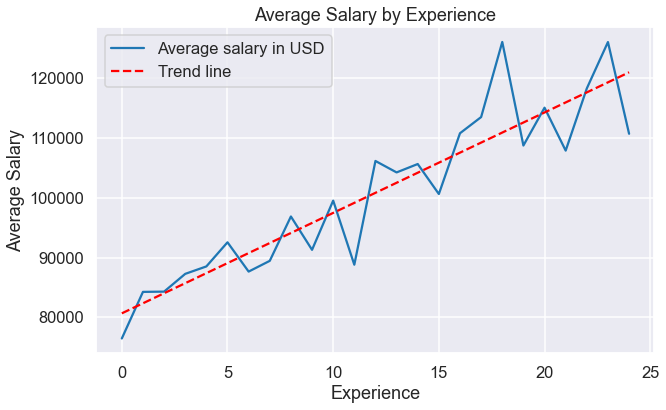

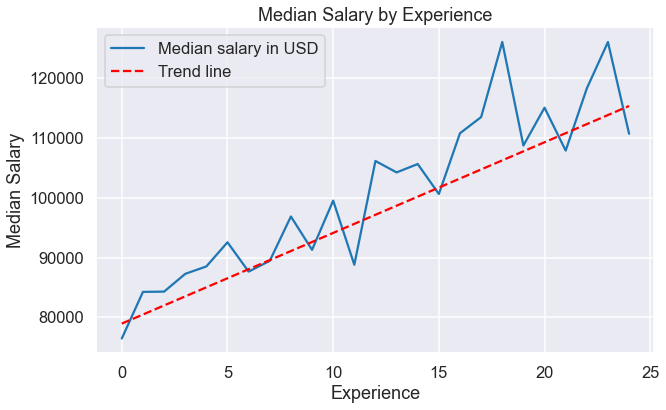

In [18]:
sns.set_style("darkgrid")
sns.set_context("talk")  # controls the size of texts for graphs
# only using x <= 25, since data above 25 is scarce
mean_salary_table = prof_table[['EXPERIENCE', 'SALARY_USD']].groupby(by='EXPERIENCE', as_index=False).mean().head(25)
plt.figure(figsize=(10, 5))
plt.plot('EXPERIENCE', 'SALARY_USD', data=mean_salary_table)
plt.xlabel('Experience')
plt.ylabel('Average Salary')
plt.title('Average Salary by Experience')

# trend line
x, y = mean_salary_table['EXPERIENCE'], mean_salary_table['SALARY_USD']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
legends = ['Average salary in USD', 'Trend line']
plt.legend(legends)

plt.show()

median_salary_table = prof_table[['EXPERIENCE', 'SALARY_USD']].groupby(by='EXPERIENCE', as_index=False).median().head(25)
plt.figure(figsize=(10, 5))
plt.plot('EXPERIENCE', 'SALARY_USD', data=mean_salary_table)
plt.xlabel('Experience')
plt.ylabel('Median Salary')
plt.title('Median Salary by Experience')

# trend line
k, v = median_salary_table['EXPERIENCE'], median_salary_table['SALARY_USD']
z = np.polyfit(k, v, 1)
p = np.poly1d(z)
plt.plot(k,p(k),"r--")
legends = ['Median salary in USD', 'Trend line']
plt.legend(legends)

plt.show()

* ### Observations

As clearly presented by both data and graphs above, the trend indicates more experience results in higher salary.

## Salary vs Education

In [19]:
prof_table['EDUCATION'].unique()

array(['Masters', 'None (no degree completed)', 'Associates (2 years)',
       'Bachelors (4 years)', 'Doctorate/PhD'], dtype=object)

In [20]:
# I want to know whether education level affects the median salary of data professionals
def clean_edu(edu_col):
    '''
    Organize education levels to simpler terms
    
        Args:
            edu_col (list): a list of education levels
        
        Return:
            updated_edu (list): a list of updated education levels
    '''
    updated_edu = []
    for education in edu_col:
        if 'none' in education.lower():
            updated_edu.append('None Degree')
        elif 'associate' in education.lower():
            updated_edu.append('Associates')
        elif 'bachelor' in education.lower():
            updated_edu.append('Bachelors')
        elif 'master' in education.lower():
            updated_edu.append('Masters')            
        elif 'doctor' in education.lower():
            updated_edu.append('PhD')
        else:
            pass
    return updated_edu

prof_table['EDUCATION'] = clean_edu(prof_table['EDUCATION'])
print('Unique job titles')
print(prof_table['EDUCATION'].unique())

Unique job titles
['Masters' 'None Degree' 'Associates' 'Bachelors' 'PhD']


In [21]:
# see how much education was completed for most data professionals.
edu_pivot = prof_table['EDUCATION'].value_counts()
print(edu_pivot)

Bachelors      3168
Masters        1074
None Degree    1016
Associates      664
PhD              44
Name: EDUCATION, dtype: int64


In [22]:
edu_order_list = ['None Degree', 'Associates', 'Bachelors', 'Masters', 'PhD']
for edu_level in edu_order_list:
    print(edu_level)
    print(salary_stat_level(prof_table.loc[prof_table['EDUCATION'] == edu_level]))

None Degree
{'Mean': OrderedDict([('Beginner', 82536.26), ('Intermediate', 88848.21), ('Advanced', 92353.91), ('Expert', 102594.78)]), 'Median': OrderedDict([('Beginner', 77000.0), ('Intermediate', 82000.0), ('Advanced', 90000.0), ('Expert', 95000.0)])}
Associates
{'Mean': OrderedDict([('Beginner', 79992.64), ('Intermediate', 79924.85), ('Advanced', 92043.97), ('Expert', 98470.97)]), 'Median': OrderedDict([('Beginner', 76000.0), ('Intermediate', 74175.5), ('Advanced', 85000.0), ('Expert', 100000.0)])}
Bachelors
{'Mean': OrderedDict([('Beginner', 86484.33), ('Intermediate', 90885.91), ('Advanced', 94766.92), ('Expert', 109015.36)]), 'Median': OrderedDict([('Beginner', 85000.0), ('Intermediate', 88000.0), ('Advanced', 92103.0), ('Expert', 103000.0)])}
Masters
{'Mean': OrderedDict([('Beginner', 80689.14), ('Intermediate', 88835.69), ('Advanced', 93007.27), ('Expert', 116620.4)]), 'Median': OrderedDict([('Beginner', 80000.0), ('Intermediate', 87200.0), ('Advanced', 95000.0), ('Expert', 110

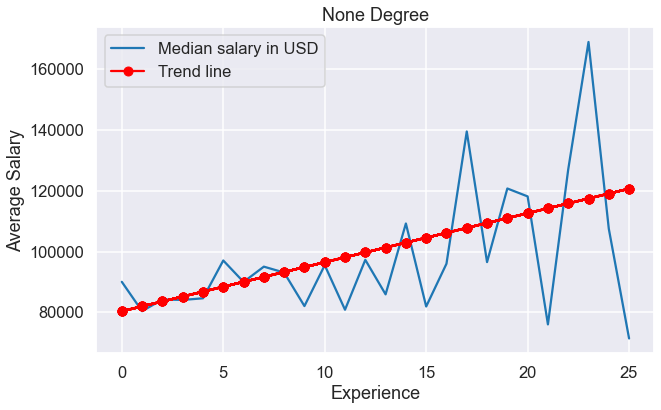

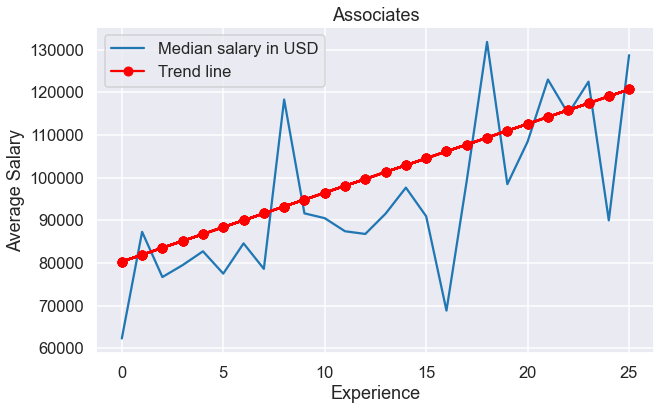

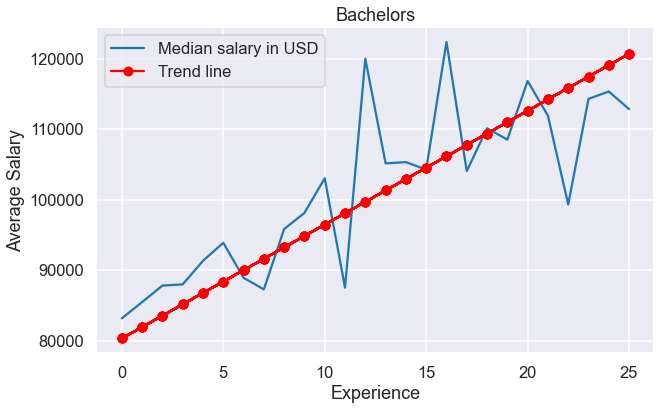

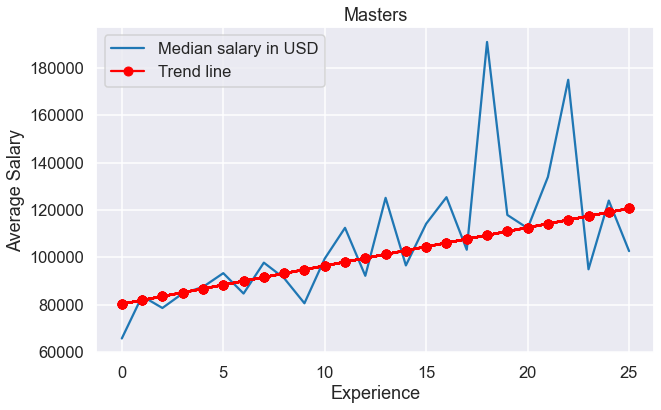

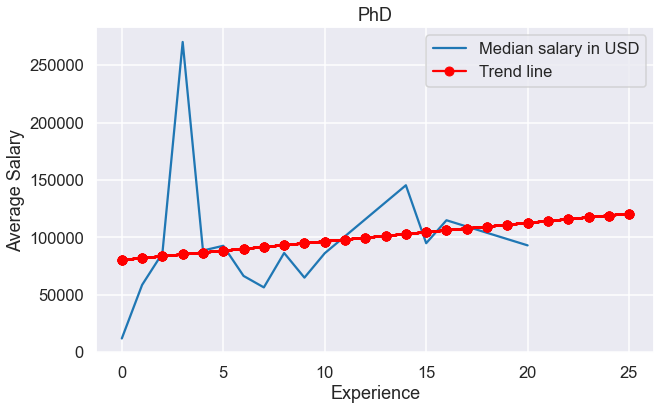

In [23]:
salary_education = prof_table[['EDUCATION', 'SALARY_USD', 'EXPERIENCE']
                             ].groupby(by=['EDUCATION', 'EXPERIENCE'], as_index=False).mean()
salary_education_25 = salary_education[salary_education['EXPERIENCE'] <= 25]

for education in edu_order_list:
    plt.figure(figsize=(10, 6))
    plt.plot('EXPERIENCE', 'SALARY_USD', data=salary_education_25[salary_education_25['EDUCATION'] == education])
    plt.title(education)
    plt.xlabel('Experience')
    plt.ylabel('Average Salary')
    
    x, y = salary_education_25['EXPERIENCE'], salary_education_25['SALARY_USD']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    legends = ['Median salary in USD', 'Trend line']
    plt.legend(legends)
    plt.show()

* ### Observations

It's difficult to determine the contribution of education to salary from the information above.

I believe this is the result of having highly varying quantity of collected data for each education-level group.
For instance, there were 3168 Bachelors compared to 44 PhDs, so it's inenvitable to have volatile graphs.

The lack of sample sizes for some groups has mostly likely caused the skewed outcome. To my belief,
if there were more samples for all groups, the graphs would've displayed a significantly different outcome.

Let's create a correlation matrix to get a better understanding of the data.

## Correlation Matrix of Features

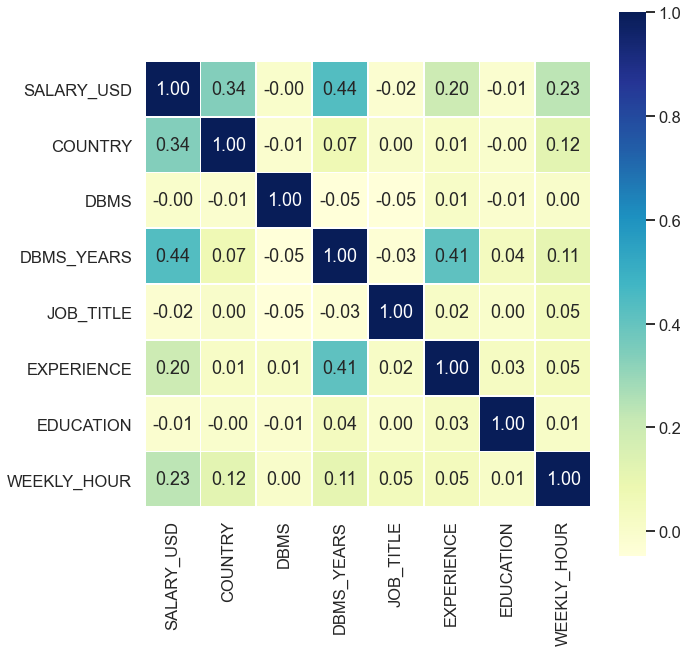

In [24]:
encoded_df = prof_table.apply(preprocessing.LabelEncoder().fit_transform)
encoded_df = encoded_df.corr()

plt.figure(figsize =(10, 10))
sns.heatmap(data=encoded_df, cmap='YlGnBu', fmt=".2f",
            linewidth=1, square=True, annot=True)
plt.show()

* ### Observations

3 features with the higehst coefficient values are:
* Country
* DBMS_YEARS
* WEEKLY_HOUR

**Note**: I've realized that, I completely disregarded the WEEKLY_HOUR column while calculating average and mean salaries.
Since weekly hours are varying, it would've been a better approach to do an analysis on salary/weekly hours. 

Also, interestingly, salary has the strongest correlation with DBMS_YEARS.
Let's create a graph to make a final observation.

## Salary vs DBMS_YEARS

In [25]:
print(prof_table['DBMS_YEARS'].sort_values().unique())

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    38  1050  2003
  2004  2008 30331 53716]


In [28]:
outlier_indexes = prof_table.loc[prof_table['DBMS_YEARS'] >= 50].index  # setting 50 as an outlier boundary
prof_table.drop(outlier_indexes, inplace=True)

In [30]:
print(prof_table['DBMS_YEARS'].sort_values().unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 38]


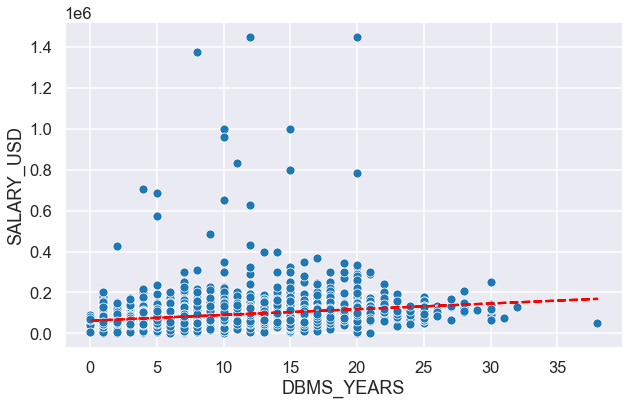

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DBMS_YEARS', y='SALARY_USD', data=prof_table)

x, y = prof_table['DBMS_YEARS'], prof_table['SALARY_USD']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

* ### Observations

It's difficult to make a statement with this graph. I think the majority of the points got clustered due to the wide range of Y values (salaries). Hence, graphing mean and median salaries vs DBMS years might work better. 

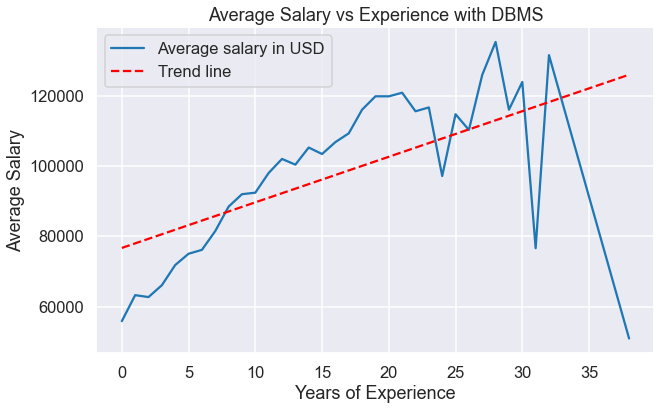

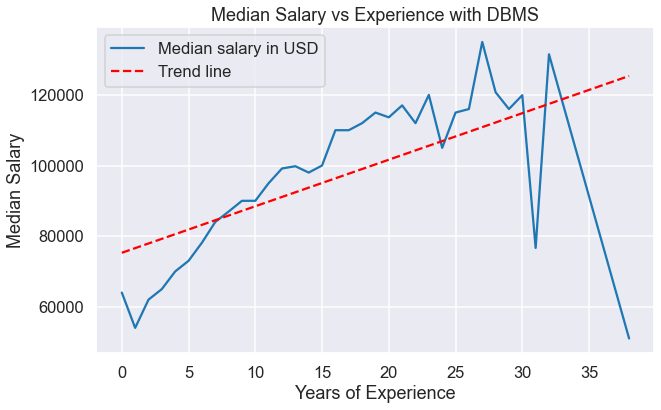

In [33]:
mean_salary_dbms = prof_table[['SALARY_USD', 'DBMS_YEARS']].groupby(by=['DBMS_YEARS'], as_index=False).mean()
median_salary_dbms = prof_table[['SALARY_USD', 'DBMS_YEARS']].groupby(by=['DBMS_YEARS'], as_index=False).median()

# the first graph
plt.figure(figsize=(10, 6))
plt.plot('DBMS_YEARS', 'SALARY_USD', data=mean_salary_dbms)
plt.title('Average Salary vs Experience with DBMS')
plt.xlabel('Years of Experience')
plt.ylabel('Average Salary')

x, y = mean_salary_dbms['DBMS_YEARS'], mean_salary_dbms['SALARY_USD']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
legends = ['Average salary in USD', 'Trend line']
plt.legend(legends)
plt.show()

# the second graph
plt.figure(figsize=(10, 6))
plt.plot('DBMS_YEARS', 'SALARY_USD', data=median_salary_dbms)
plt.title('Median Salary vs Experience with DBMS')
plt.xlabel('Years of Experience')
plt.ylabel('Median Salary')

x, y = median_salary_dbms['DBMS_YEARS'], median_salary_dbms['SALARY_USD']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
legends = ['Median salary in USD', 'Trend line']
plt.legend(legends)
plt.show()

* ### Final observations


* Salary is highly correlated with DBMS_YEARS 
* After 20 years of experience, data is really limited, so the graph becomes extremely unstable

## Results & Reflection

| Question | Result |
| -------- | ------ |
| The preference of database management systems | Microsoft SQL Server |
| Distribution of data related jobs | Top 3: DBA, Developer, Architech |
| Job Locations - Countries | Top 3 - The U.S, United Kingdom, Canada |
| The most popular data job's average salaries | Average Salary in the US: 107685, outside of the US: 64806 |
| The most popular data job's median salaries | Median Salary in the US: 102000, outside of the US: 60000|
| Corrleation between salaries and experience | A strong positive correlation |
| Corrleation between salaries and education | A positive corrleation |

-------------------------------
**Reflection**:

* It would been better to clean data of all columns at the start - dropping rows for each observation most likely caused minor differences in outcomes
* Values of salary / weekly hour should've been used to calculate mean/average salaries

**Thoughts**

* If there was more collected data, results would be very different for analyses on salaries
* There is a reason why the U.S. is so dominant when it comes to IT - a lot of talents desire to work there as they get paid substantially more. Also the world's biggest IT companies like Amazon, Google, Microsoft, etc. are located in the U.S.
* I was surprised to see that location factor had more influence than experience to salary for this analysis
* This is 2017-2018 data and given IT is a field of rapid changes, the same analysis of today's data might yield a very different result 